# NeRF

## 0. Hyperparameters

In [45]:
import torch
import numpy as np
import imageio.v2 as imageio
import cv2
import argparse
import json
import os
import time
from typing import Tuple
from tqdm import tqdm, trange

args = {
    # 1. Model
    "coarse_net_width": 256,
    "coarse_net_depth": 8,
    "fine_net_width": 256,
    "fine_net_depth": 8,

    # 2. Others
    'datadir': './data/nerf_synthetic/lego',
    'resample_rate': 0.5,
    'lrate': 0.0005,
    'lrate_decay': 500,
}
args = argparse.Namespace(**args)
torch.set_default_device('cuda')
torch.set_default_dtype(torch.float32)

## 1. Load Data and Preprocess

In [46]:
def load_data_blender(in_type: str, in_skip: int = 1) -> Tuple[np.ndarray, np.ndarray, int, float]:
    with open(os.path.normpath(os.path.join(args.datadir, 'transforms_{}.json'.format(in_type))), 'r') as fp:
        _meta = json.load(fp)
        _image_array = []
        _pose_array = []
        for _frame in _meta['frames'][::in_skip]:
            _image_array.append(
                imageio.imread(os.path.normpath(os.path.join(args.datadir, _frame['file_path'] + '.png'))))
            _pose_array.append(np.array(_frame['transform_matrix']))
        _images = (np.array(_image_array) / 255.).astype(np.float32)
        _poses = np.array(_pose_array).astype(np.float32)
        _frames = len(_image_array)
        _angle = _meta['camera_angle_x']
        return _images, _poses, _frames, _angle


def resample_images(in_origin: np.ndarray, in_focal, in_rate: float) -> Tuple[np.ndarray, int, int, float]:
    _target_height, _target_width, _target_focal = int(in_origin.shape[1] * in_rate), int(
        in_origin.shape[2] * in_rate), in_focal * in_rate
    _ret = np.zeros((in_origin.shape[0], _target_height, _target_width, 4))
    for _idx, _image in enumerate(in_origin):
        _ret[_idx] = cv2.resize(_image, (_target_width, _target_height), interpolation=cv2.INTER_AREA)
    return _ret, _target_width, _target_height, _target_focal


def make_white_background(in_origin: np.ndarray) -> np.ndarray:
    return in_origin[..., :3] * in_origin[..., -1:] + (1. - in_origin[..., -1:])

## 2. Model

In [47]:
class NeRF(torch.nn.Module):
    def __init__(self, net_width: int, net_depth: int, input_channel: int, input_channel_views: int, skips: list):
        super(NeRF, self).__init__()
        self.skips = skips

        self.points_layers = torch.nn.ModuleList(
            [torch.nn.Linear(in_features=input_channel, out_features=net_width)] + [
                torch.nn.Linear(in_features=net_width, out_features=net_width) if i not in skips else torch.nn.Linear(
                    in_features=(net_width + input_channel), out_features=net_width) for i in range(net_depth - 1)])
        self.views_layers = torch.nn.ModuleList(
            [torch.nn.Linear(in_features=input_channel_views + net_width, out_features=net_width // 2)])

        self.feature_layer = torch.nn.Linear(net_width, net_width)
        self.alpha_layer = torch.nn.Linear(net_width, 1)
        self.rgb_layer = torch.nn.Linear(net_width // 2, 3)

    def forward(self, points: torch.Tensor, views: torch.Tensor):
        h = points
        for i, l in enumerate(self.points_layers):
            h = self.points_layers[i](h)
            h = torch.nn.functional.relu(h)
            if i in self.skips:
                h = torch.cat([points, h], -1)

        alpha = self.alpha_layer(h)
        feature = self.feature_layer(h)
        h = torch.cat([feature, views], -1)

        for i, l in enumerate(self.views_layers):
            h = self.views_layers[i](h)
            h = torch.nn.functional.relu(h)

        rgb = self.rgb_layer(h)
        outputs = torch.cat([rgb, alpha], -1)
        return outputs

## 3. Position Encoding

In [48]:
def generate_rays(in_width: int, in_height: int, in_focal: float, in_pose: torch.Tensor) -> Tuple[
    torch.Tensor, torch.Tensor]:
    _x, _y = torch.meshgrid(torch.linspace(0, in_width - 1, in_width), torch.linspace(0, in_height - 1, in_height),
                            indexing='xy')
    _rays_dirs = torch.matmul(
        torch.stack([(_x - in_width / 2.) / in_focal, -(_y - in_height / 2.) / in_focal, -torch.ones_like(_x)], -1),
        in_pose[0:3, 0:3].T)  # seems no need to normalize
    _rays_oris = in_pose[0:3, -1].expand(_rays_dirs.shape)
    return _rays_oris, _rays_dirs


def generate_query_points(in_rays_oris: torch.Tensor, in_rays_dirs: torch.Tensor, in_near: float, in_far: float,
                          in_batch_size: int, in_sample_size: int) -> Tuple[
    torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    _height, _width = in_rays_oris.shape[0], in_rays_oris.shape[1]
    _coords = torch.reshape(torch.stack(
        torch.meshgrid(torch.linspace(0, _height - 1, _height), torch.linspace(0, _width - 1, _width),
                       indexing='ij'), -1), [-1, 2])
    _selected_coords = _coords[np.random.choice(_coords.shape[0], size=[in_batch_size], replace=False)].long()
    _selected_rays_oris = in_rays_oris[_selected_coords[:, 0], _selected_coords[:, 1]]
    _selected_rays_dirs = in_rays_dirs[_selected_coords[:, 0], _selected_coords[:, 1]]
    _t_vals = torch.linspace(0., 1., steps=in_sample_size)
    _z_vals = 1. / (1. / in_near * (1. - _t_vals) + 1. / in_far * _t_vals)
    _z_vals = _z_vals.expand([in_batch_size, in_sample_size])

    if True:  # perturb samples
        _mid = .5 * (_z_vals[..., 1:] + _z_vals[..., :-1])
        _upper = torch.cat([_mid, _z_vals[..., -1:]], -1)
        _lower = torch.cat([_z_vals[..., :1], _mid], -1)
        _t_rand = torch.rand(_z_vals.shape)
        _z_vals = _lower + (_upper - _lower) * _t_rand

    _sampled_points = _selected_rays_oris[..., None, :] + _selected_rays_dirs[..., None, :] * _z_vals[..., :, None]
    _view_dirs = _selected_rays_dirs / torch.norm(_selected_rays_dirs, dim=-1, keepdim=True)
    _view_dirs = _view_dirs[:, None].expand(_sampled_points.shape)
    return _sampled_points, _view_dirs, _z_vals, _selected_rays_dirs, _selected_coords


def generate_position_encoding_fn(in_multires: int):
    _input_dims = 3
    _out_dim = _input_dims
    _max_freq_log2 = in_multires - 1
    _num_freq = in_multires
    _freq_bands = 2. ** torch.linspace(0., _max_freq_log2, steps=_num_freq)

    embed_fns = [lambda x: x]
    for _freq in _freq_bands:
        for _p_fn in [torch.sin, torch.cos]:
            embed_fns.append(lambda x, p_fn=_p_fn, freq=_freq: p_fn(x * freq))
            _out_dim += _input_dims

    _embed_fn = lambda x: torch.cat([fn(x) for fn in embed_fns], -1)
    return _embed_fn, _out_dim

## 4. Volume Rendering

In [49]:
def render(in_raw: torch.Tensor, in_z_vals: torch.Tensor, in_rays_dirs: torch.Tensor) -> Tuple[
    torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    raw2alpha = lambda raw, dists, act_fn=torch.nn.functional.relu: 1. - torch.exp(-act_fn(raw) * dists)

    dists = in_z_vals[..., 1:] - in_z_vals[..., :-1]
    dists = torch.cat([dists, torch.tensor([1e10]).expand(dists[..., :1].shape)], -1)  # [N_rays, N_samples]
    dists = dists * torch.norm(in_rays_dirs[..., None, :], dim=-1)
    rgb = torch.sigmoid(in_raw[..., :3])  # [N_rays, N_samples, 3]
    alpha = raw2alpha(in_raw[..., 3], dists)  # [N_rays, N_samples]
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1. - alpha + 1e-10], -1), -1)[:, :-1]
    rgb_map = torch.sum(weights[..., None] * rgb, -2)  # [N_rays, 3]
    depth_map = torch.sum(weights * in_z_vals, -1)
    disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map), depth_map / torch.sum(weights, -1))
    acc_map = torch.sum(weights, -1)
    rgb_map = rgb_map + (1. - acc_map[..., None])
    return rgb_map, disp_map, acc_map, weights, depth_map

## 5. Training

In [50]:
IMAGES_TRAIN, POSE_TRAIN, FRAMES_TRAIN, ANGLE_TRAIN = load_data_blender('train', 1)
IMAGES_VAL, POSE_VAL, FRAMES_VAL, ANGLE_VAL = load_data_blender('val', 8)
IMAGES_TEST, POSE_TEST, FRAMES_TEST, ANGLE_TEST = load_data_blender('test', 8)
WIDTH_ORIGIN, HEIGHT_ORIGIN = IMAGES_TRAIN.shape[2], IMAGES_TRAIN.shape[1]
FOCAL_ORIGIN = 0.5 * WIDTH_ORIGIN / np.tan(0.5 * ANGLE_TRAIN)
# IMAGES_TRAIN_RESAMPLED, WIDTH_TRAIN_RESAMPLED, HEIGHT_TRAIN_RESAMPLED, FOCAL_TRAIN_RESAMPLED = \
#     resample_images(IMAGES_TRAIN, FOCAL_ORIGIN, args.resample_rate)
# IMAGES_VAL_RESAMPLED, WIDTH_VAL_RESAMPLED, HEIGHT_VAL_RESAMPLED, FOCAL_VAL_RESAMPLED = \
#     resample_images(IMAGES_VAL, FOCAL_ORIGIN, args.resample_rate)
# IMAGES_TEST_RESAMPLED, WIDTH_TEST_RESAMPLED, HEIGHT_TEST_RESAMPLED, FOCAL_TEST_RESAMPLED = \
#     resample_images(IMAGES_TEST, FOCAL_ORIGIN, args.resample_rate)

IMAGES_TRAIN_WHITE_BACKGROUND = make_white_background(IMAGES_TRAIN)
IMAGES_VAL_WHITE_BACKGROUND = make_white_background(IMAGES_VAL)
IMAGES_TEST_WHITE_BACKGROUND = make_white_background(IMAGES_TEST)

EMBED_fn, OUT_DIM = generate_position_encoding_fn(10)
EMBED_VIEW_fn, OUT_VIEW_DIM = generate_position_encoding_fn(4)
MODEL_COARSE = NeRF(args.coarse_net_width, args.coarse_net_depth, OUT_DIM, OUT_VIEW_DIM, [4])
GRAD_VARS = list(MODEL_COARSE.parameters())
OPTIMIZER = torch.optim.Adam(params=GRAD_VARS, lr=args.lrate, betas=(0.9, 0.999))

In [51]:
IDX_TRAIN = np.arange(FRAMES_TRAIN)
IDX_VAL = np.arange(FRAMES_VAL)
IDX_TEST = np.arange(FRAMES_TEST)
img2mse = lambda x, y: torch.mean((x - y) ** 2)
mse2psnr = lambda x: -10. * torch.log(x) / torch.log(torch.tensor([10.]))

loss_graph = []
for epoch in trange(10000):
    time0 = time.time()

    # 1. Forward
    idx_image = np.random.choice(IDX_TRAIN)
    target_image = torch.tensor(IMAGES_TRAIN_WHITE_BACKGROUND[idx_image]).float()
    target_pose = torch.tensor(POSE_TRAIN[idx_image]).float()
    ray_oris, ray_dirs = generate_rays(in_width=WIDTH_ORIGIN, in_height=HEIGHT_ORIGIN, in_focal=FOCAL_ORIGIN,
                                       in_pose=target_pose)
    points, view_dirs, z_vars, selected_rays_dirs, selected_coords = generate_query_points(in_rays_oris=ray_oris,
                                                                                           in_rays_dirs=ray_dirs,
                                                                                           in_near=2.,
                                                                                           in_far=6.,
                                                                                           in_batch_size=1024,
                                                                                           in_sample_size=64)
    points_flat = torch.reshape(points, [-1, points.shape[-1]])
    view_dirs_flat = torch.reshape(view_dirs, [-1, view_dirs.shape[-1]])
    embedded_points = EMBED_fn(points_flat)
    embedded_view_dirs = EMBED_VIEW_fn(view_dirs_flat)
    raw_flat = MODEL_COARSE(embedded_points, embedded_view_dirs)
    raw = torch.reshape(raw_flat, list(points.shape[:-1]) + [raw_flat.shape[-1]])

    rgb_map, disp_map, acc_map, weights, depth_map = render(in_raw=raw, in_z_vals=z_vars,
                                                            in_rays_dirs=selected_rays_dirs)

    # 2. Optimization
    OPTIMIZER.zero_grad()
    target_s = target_image[selected_coords[:, 0], selected_coords[:, 1]]
    img_loss = img2mse(rgb_map, target_s)
    loss = img_loss
    psnr = mse2psnr(img_loss)
    loss.backward()
    OPTIMIZER.step()

    # NOTE: IMPORTANT!
    ###   update learning rate   ###
    decay_rate = 0.1
    decay_steps = args.lrate_decay * 1000
    new_lrate = args.lrate * (decay_rate ** (epoch + 1 / decay_steps))
    for param_group in OPTIMIZER.param_groups:
        param_group['lr'] = new_lrate

    # 3. Loggings
    if epoch % 100 == 0:
        loss_graph.append(loss.item())
    # dt = time.time() - time0
    # print(f"Epoch: {epoch}, Loss: {loss}, Time: {dt}")

100%|██████████| 10000/10000 [12:41<00:00, 13.13it/s]


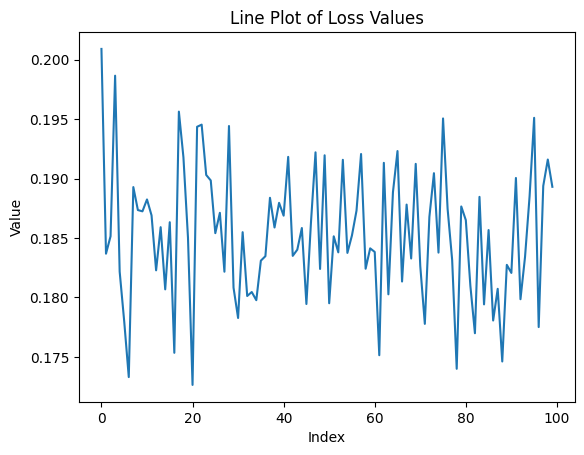

In [52]:
import matplotlib.pyplot as plt

x = range(len(loss_graph))
plt.plot(x, loss_graph)

# 添加标题和标签
plt.title('Line Plot of Loss Values')
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图像
plt.show()